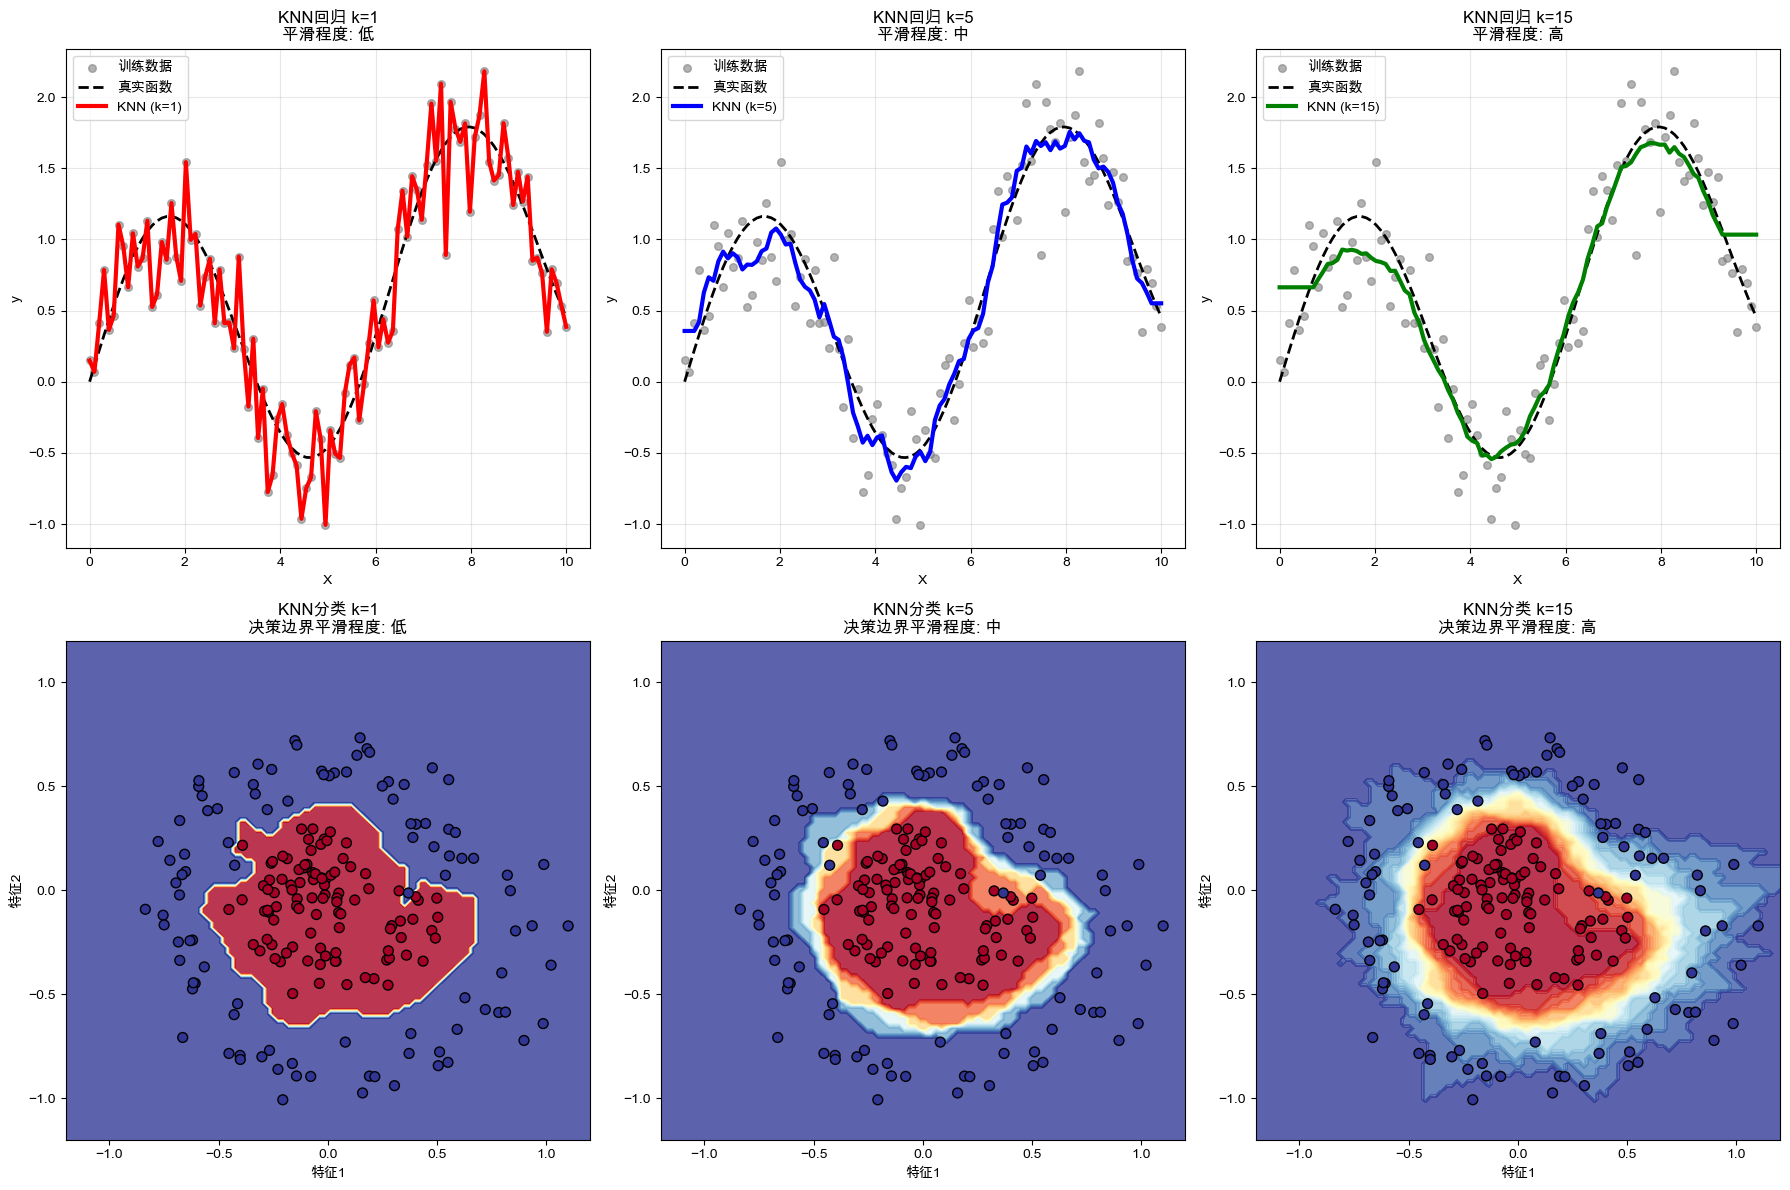

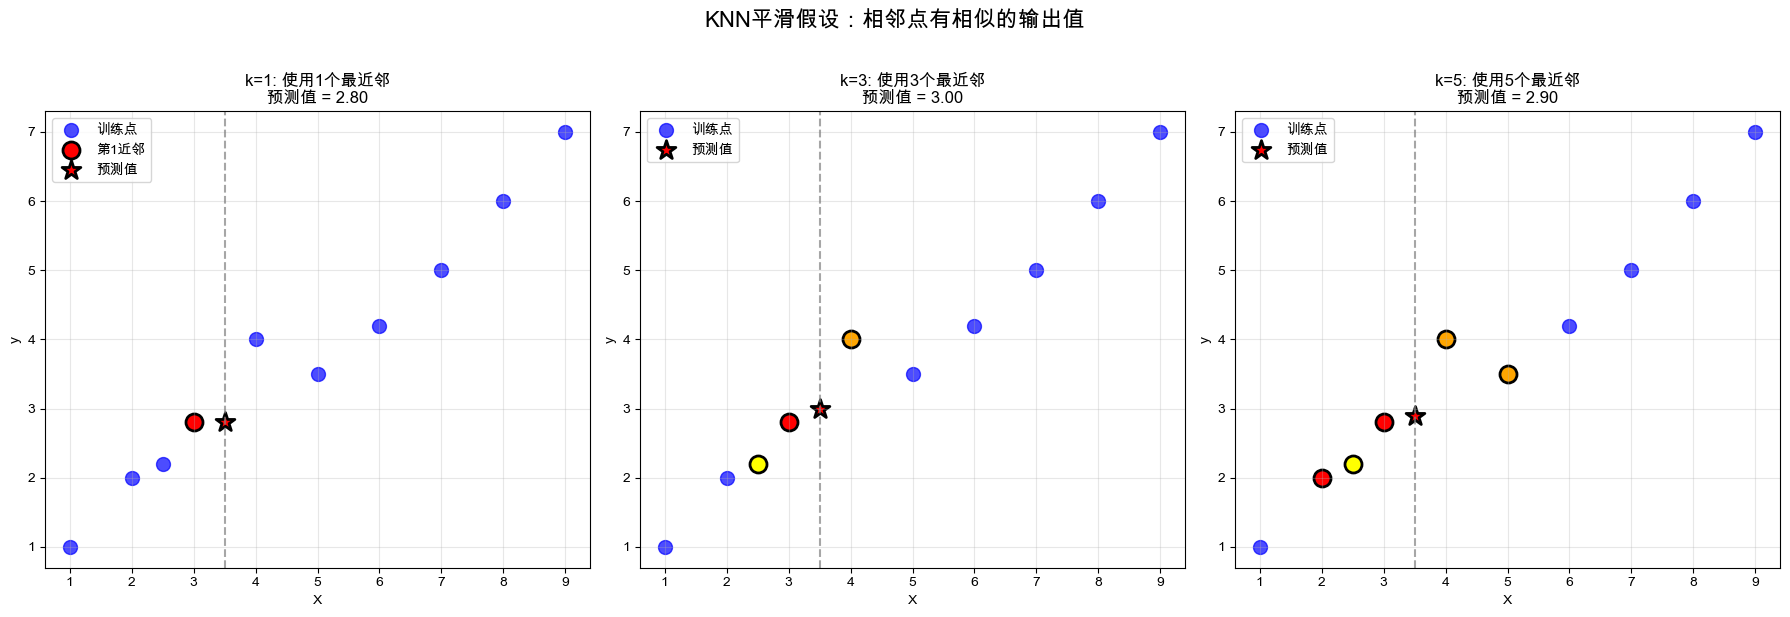

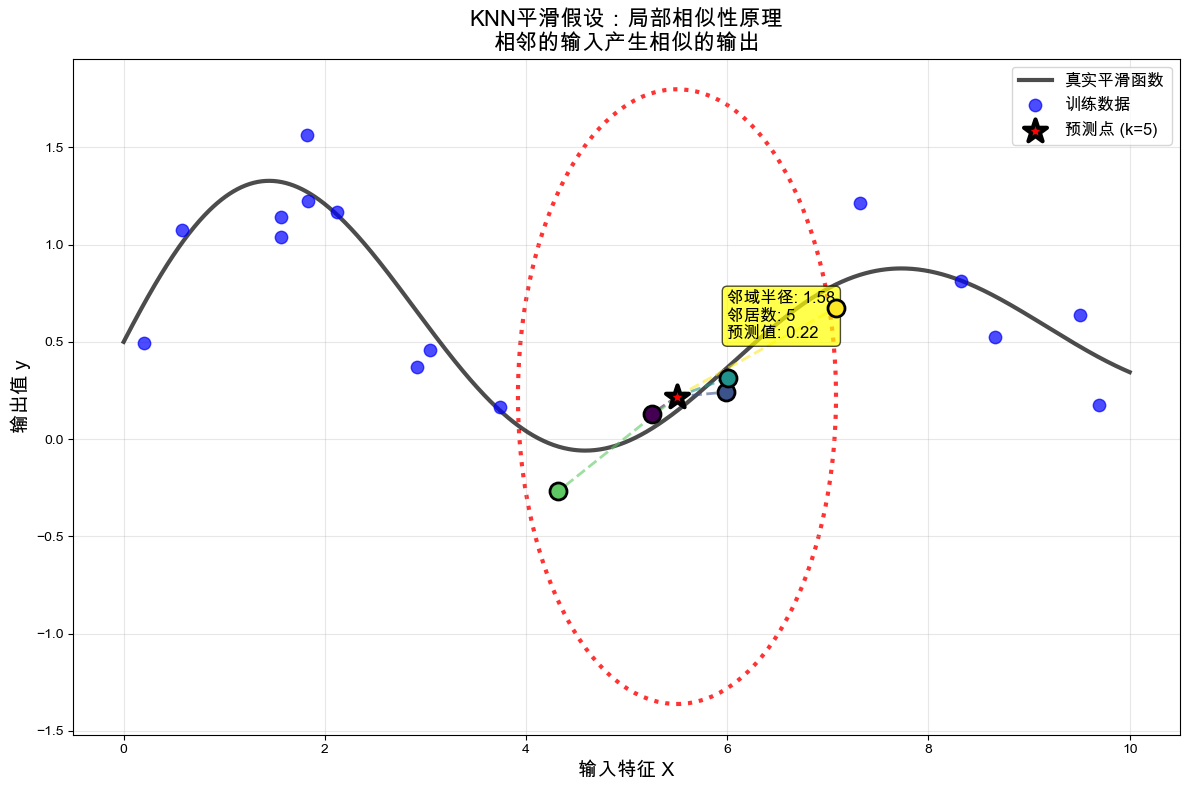

KNN核心平滑假设 (Local Smoothness Assumption)
1. 相邻的输入点应该产生相似的输出值
2. 数据在局部区域内是平滑的
3. k值控制平滑程度：
   - k小：模型复杂，可能过拟合
   - k大：模型简单，更平滑但可能欠拟合
4. 适用条件：数据密度足够高，局部相似性成立


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.datasets import make_classification, make_regression
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial Unicode MS'

# 创建图形
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ==================== 回归任务的平滑假设 ====================
np.random.seed(42)
X_reg = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = np.sin(X_reg.ravel()) + 0.1 * X_reg.ravel()
y_noisy = y_true + 0.3 * np.random.randn(100)

# 不同K值的KNN回归
k_values = [1, 5, 15]
colors = ['red', 'blue', 'green']

for i, (k, color) in enumerate(zip(k_values, colors)):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_reg, y_noisy)
    y_pred = knn.predict(X_reg)
    
    axes[0, i].scatter(X_reg, y_noisy, alpha=0.6, s=30, color='gray', label='训练数据')
    axes[0, i].plot(X_reg, y_true, 'k--', linewidth=2, label='真实函数')
    axes[0, i].plot(X_reg, y_pred, color=color, linewidth=3, label=f'KNN (k={k})')
    axes[0, i].set_title(f'KNN回归 k={k}\n平滑程度: {"低" if k==1 else "中" if k==5 else "高"}')
    axes[0, i].set_xlabel('X')
    axes[0, i].set_ylabel('y')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

# ==================== 分类任务的平滑假设 ====================
np.random.seed(42)
# 创建螺旋形数据
theta = np.linspace(0, 4*np.pi, 200)
r = theta / (4*np.pi)
X_class = np.column_stack([r * np.cos(theta), r * np.sin(theta)])
y_class = (theta > 2*np.pi).astype(int)

# 添加噪声
X_class += 0.1 * np.random.randn(*X_class.shape)

# 创建网格用于决策边界
xx, yy = np.meshgrid(np.linspace(-1.2, 1.2, 100),
                     np.linspace(-1.2, 1.2, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

k_values = [1, 5, 15]

for i, k in enumerate(k_values):
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_class, y_class)
    Z = knn_clf.predict_proba(grid_points)[:, 1]
    Z = Z.reshape(xx.shape)
    
    axes[1, i].contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
    scatter = axes[1, i].scatter(X_class[:, 0], X_class[:, 1], 
                                c=y_class, cmap='RdYlBu', 
                                edgecolors='black', s=50)
    axes[1, i].set_title(f'KNN分类 k={k}\n决策边界平滑程度: {"低" if k==1 else "中" if k==5 else "高"}')
    axes[1, i].set_xlabel('特征1')
    axes[1, i].set_ylabel('特征2')

plt.tight_layout()
plt.show()

# ==================== 详细解释平滑假设 ====================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 生成1D数据用于详细说明
np.random.seed(42)
X_demo = np.array([1, 2, 2.5, 3, 4, 5, 6, 7, 8, 9]).reshape(-1, 1)
y_demo = np.array([1, 2, 2.2, 2.8, 4, 3.5, 4.2, 5, 6, 7])

# 测试点
test_point = 3.5
test_X = np.array([[test_point]])

# 不同k值的邻居选择
k_values = [1, 3, 5]
neighbor_colors = ['red', 'orange', 'yellow']

for i, k in enumerate(k_values):
    axes[i].scatter(X_demo.ravel(), y_demo, s=100, color='blue', alpha=0.7, label='训练点')
    
    # 找到k个最近邻
    distances = np.abs(X_demo.ravel() - test_point)
    nearest_indices = np.argsort(distances)[:k]
    
    # 高亮最近邻
    for j, idx in enumerate(nearest_indices):
        axes[i].scatter(X_demo[idx], y_demo[idx], s=150, 
                       color=neighbor_colors[j % len(neighbor_colors)], 
                       edgecolor='black', linewidth=2,
                       label=f'第{j+1}近邻' if i == 0 else "")
    
    # 预测值
    predicted_value = np.mean(y_demo[nearest_indices])
    axes[i].scatter(test_point, predicted_value, s=200, color='red', 
                   marker='*', edgecolor='black', linewidth=2, label='预测值')
    
    # 垂直线显示测试点
    axes[i].axvline(x=test_point, color='gray', linestyle='--', alpha=0.7)
    
    axes[i].set_title(f'k={k}: 使用{k}个最近邻\n预测值 = {predicted_value:.2f}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('y')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('KNN平滑假设：相邻点有相似的输出值', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ==================== 理论说明图 ====================
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# 创建理想的平滑函数
x_smooth = np.linspace(0, 10, 1000)
y_smooth = np.sin(x_smooth) * np.exp(-x_smooth/8) + 0.5

# 添加一些训练点
np.random.seed(42)
x_train = np.sort(np.random.uniform(0, 10, 20))
y_train = np.sin(x_train) * np.exp(-x_train/8) + 0.5 + 0.2 * np.random.randn(20)

# 选择一个测试点和其邻居
test_x = 5.5
test_idx = np.argmin(np.abs(x_train - test_x))
k = 5

# 找到最近的k个邻居
distances = np.abs(x_train - test_x)
neighbor_indices = np.argsort(distances)[:k]

# 绘图
ax.plot(x_smooth, y_smooth, 'k-', linewidth=3, label='真实平滑函数', alpha=0.7)
ax.scatter(x_train, y_train, s=80, color='blue', alpha=0.7, label='训练数据', zorder=5)

# 高亮邻居
colors = plt.cm.viridis(np.linspace(0, 1, k))
for i, idx in enumerate(neighbor_indices):
    ax.scatter(x_train[idx], y_train[idx], s=150, color=colors[i], 
               edgecolor='black', linewidth=2, zorder=6)
    
    # 画线连接到测试点
    ax.plot([test_x, x_train[idx]], [np.mean(y_train[neighbor_indices]), y_train[idx]], 
            color=colors[i], linestyle='--', alpha=0.6, linewidth=2)

# 测试点预测
predicted_y = np.mean(y_train[neighbor_indices])
ax.scatter(test_x, predicted_y, s=300, color='red', marker='*', 
           edgecolor='black', linewidth=3, label=f'预测点 (k={k})', zorder=7)

# 添加邻域圆圈
circle_radius = np.max(np.abs(x_train[neighbor_indices] - test_x))
circle = plt.Circle((test_x, predicted_y), circle_radius, 
                   fill=False, color='red', linestyle=':', linewidth=3, alpha=0.8)
ax.add_patch(circle)

ax.set_xlabel('输入特征 X', fontsize=14)
ax.set_ylabel('输出值 y', fontsize=14)
ax.set_title('KNN平滑假设：局部相似性原理\n相邻的输入产生相似的输出', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# 添加文本说明
ax.text(test_x + 0.5, predicted_y + 0.3, 
        f'邻域半径: {circle_radius:.2f}\n'
        f'邻居数: {k}\n'
        f'预测值: {predicted_y:.2f}', 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        fontsize=12)

plt.tight_layout()
plt.show()

print("=" * 60)
print("KNN核心平滑假设 (Local Smoothness Assumption)")
print("=" * 60)
print("1. 相邻的输入点应该产生相似的输出值")
print("2. 数据在局部区域内是平滑的")
print("3. k值控制平滑程度：")
print("   - k小：模型复杂，可能过拟合")
print("   - k大：模型简单，更平滑但可能欠拟合")
print("4. 适用条件：数据密度足够高，局部相似性成立")

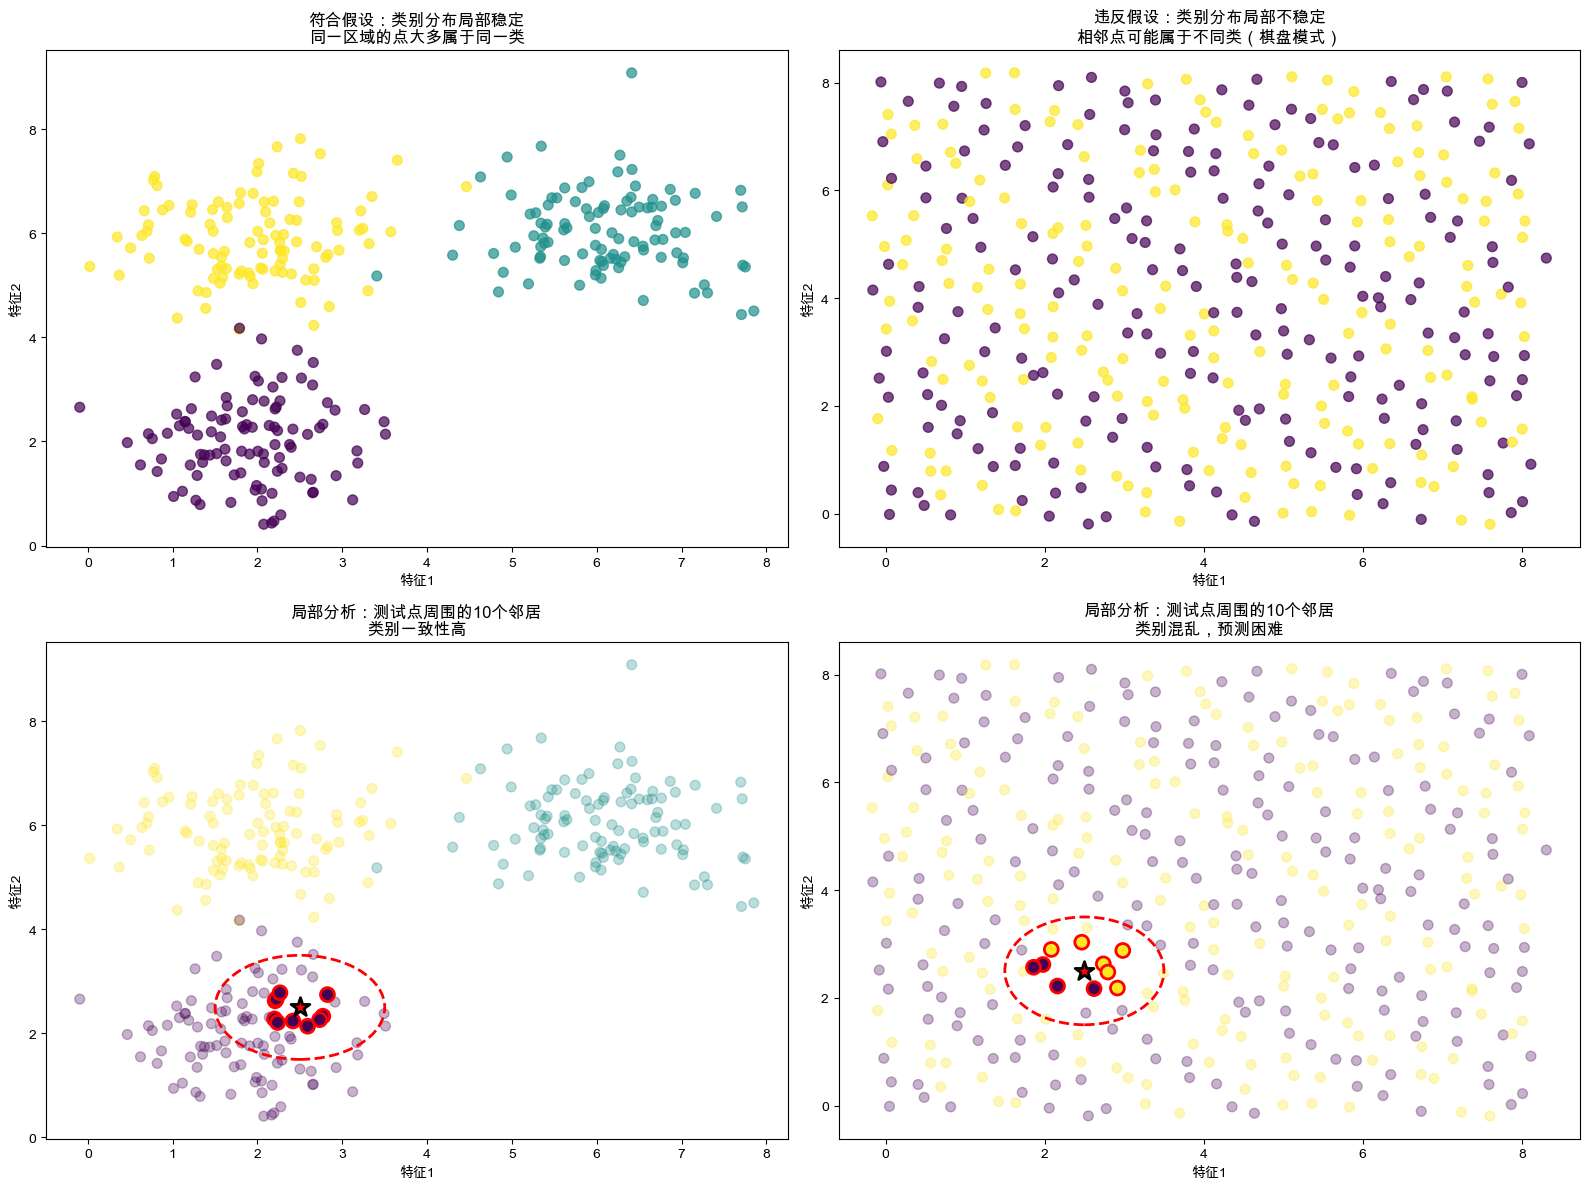

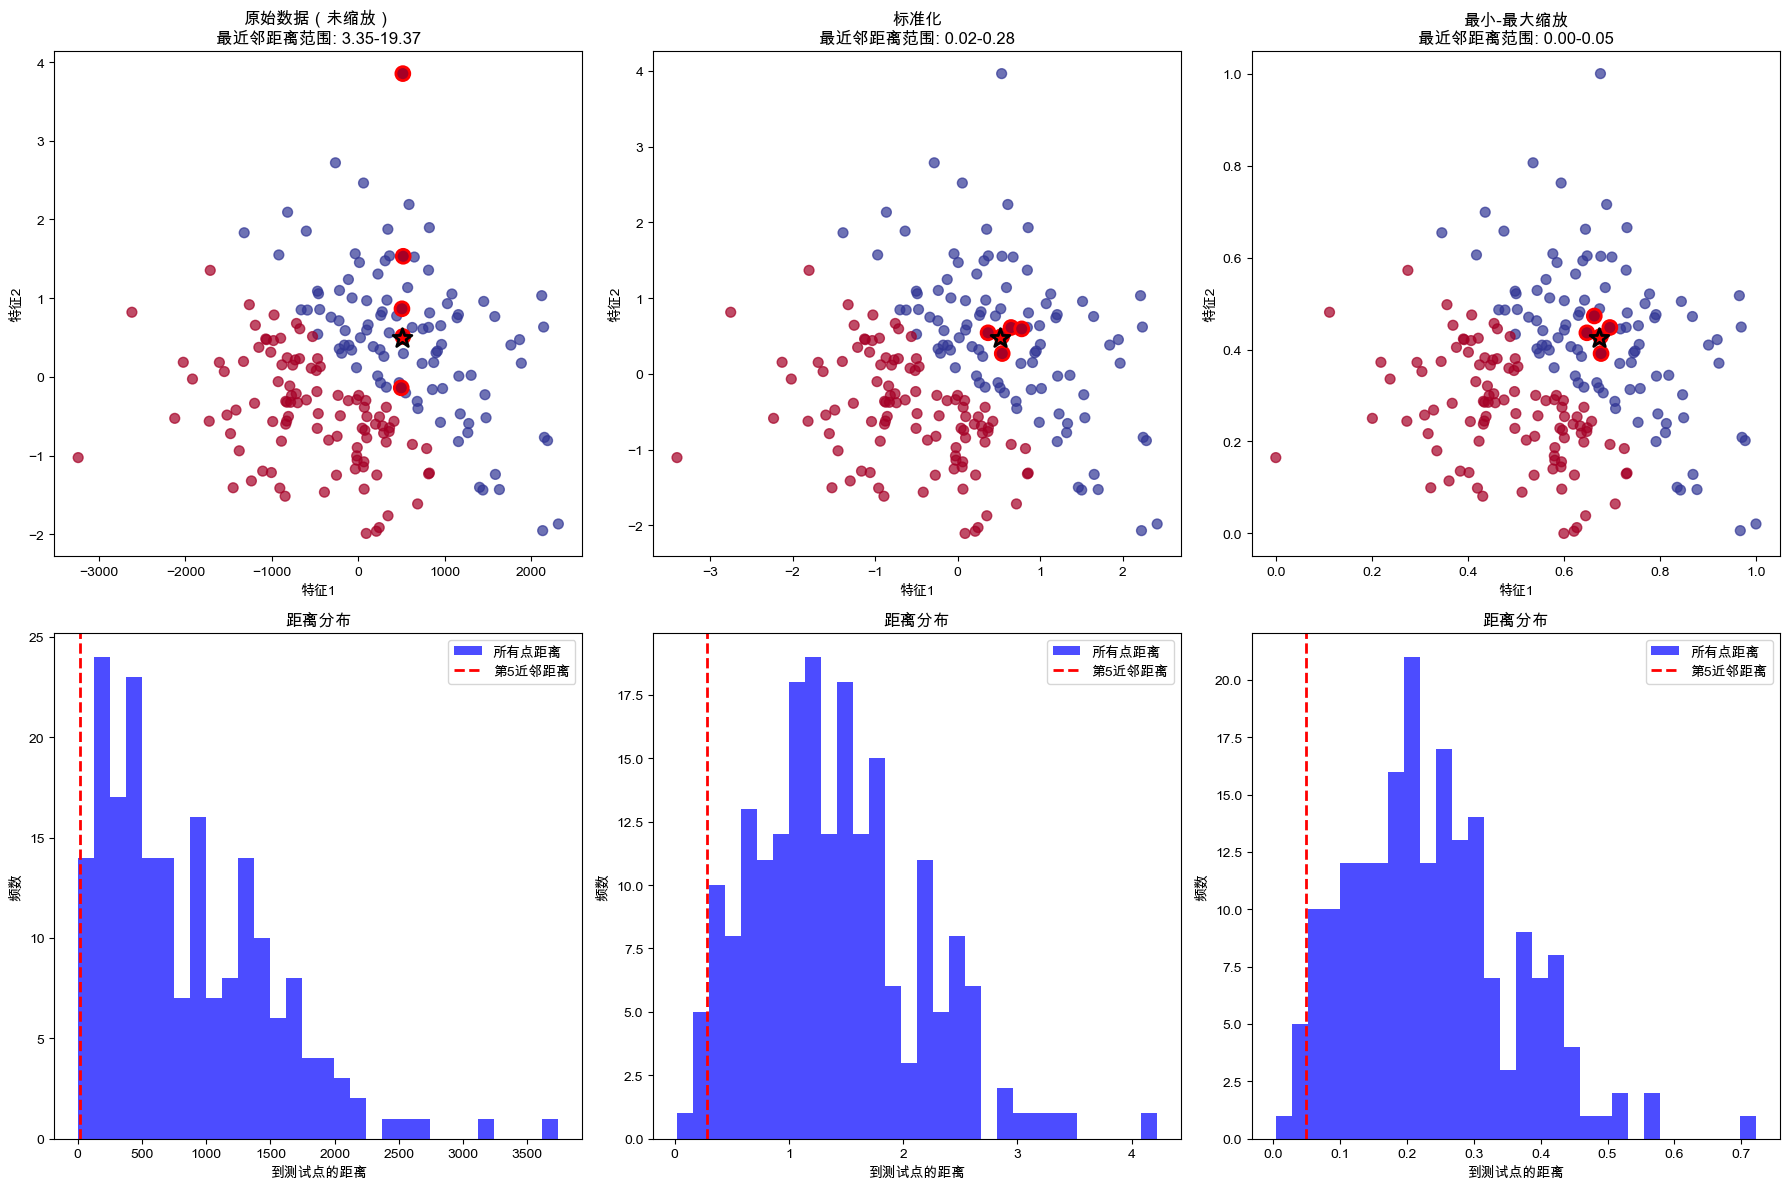

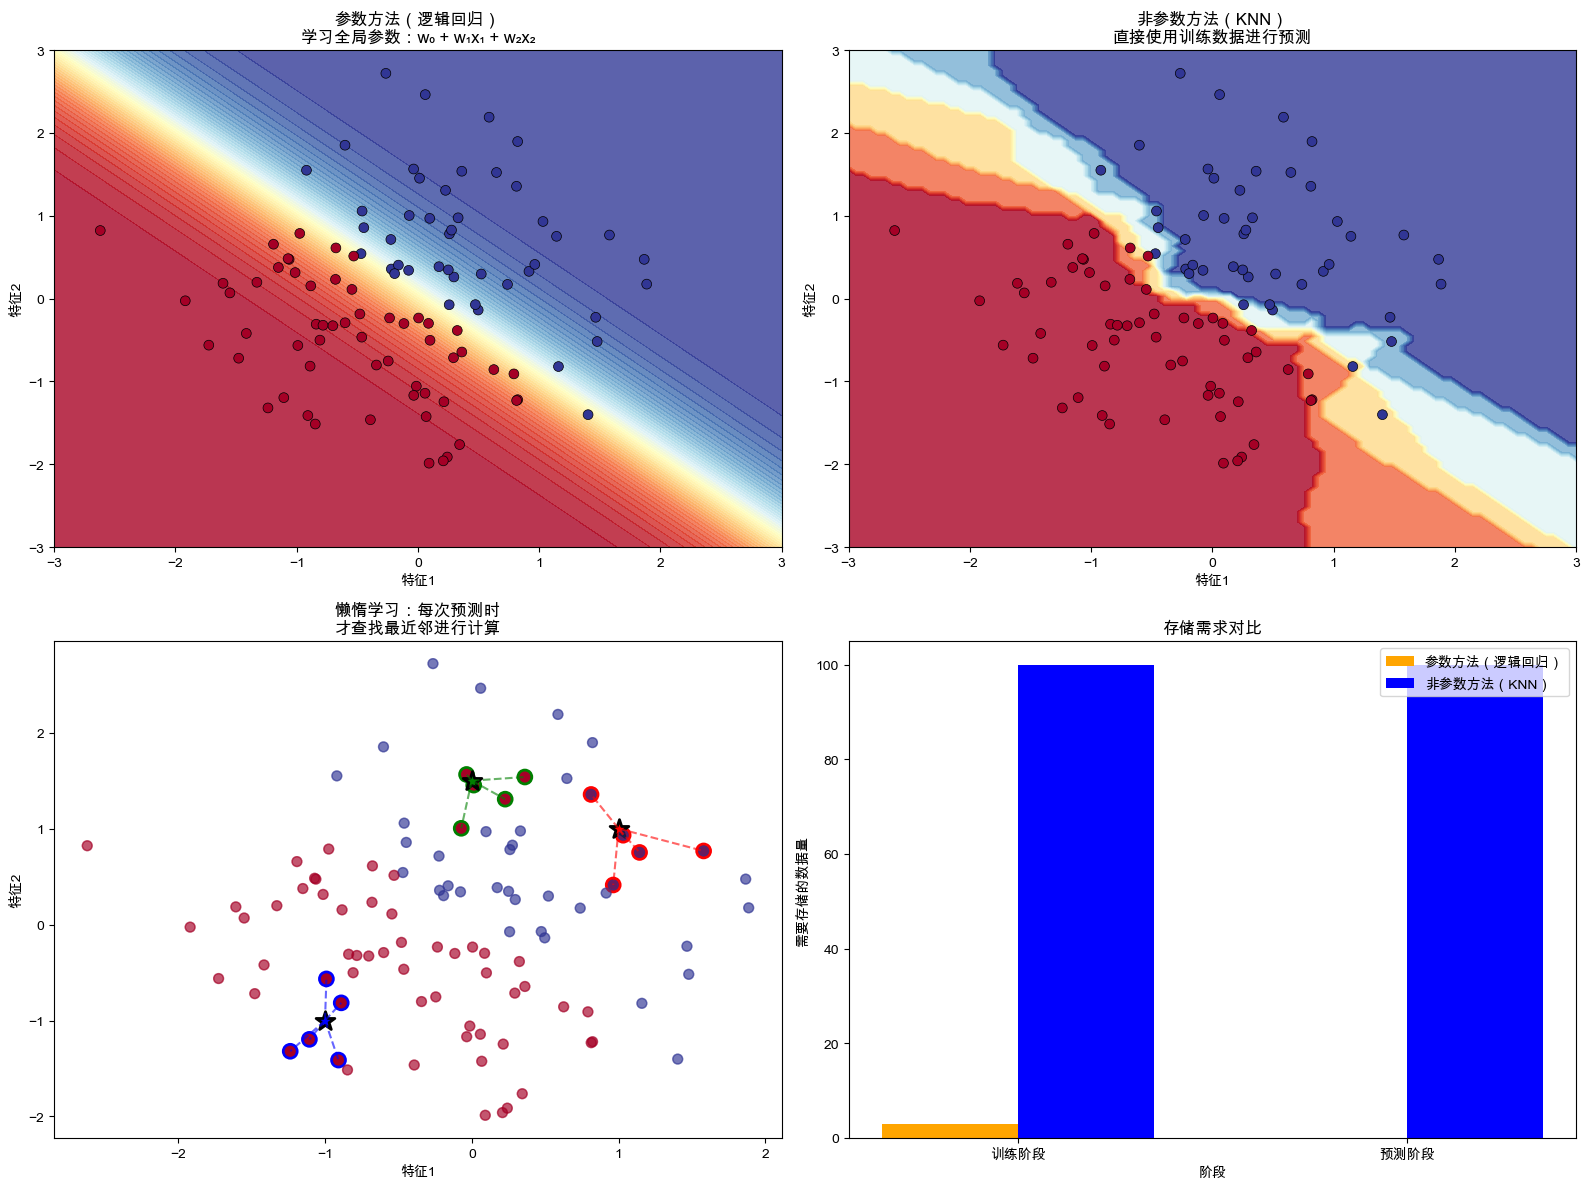

KNN的三个核心假设

1. 类别分布在局部是相对稳定的
   ✓ 一个点的类别可以用它邻居的类别来代表
   ✓ 假如一片区域大部分点是'猫'，那新落在这片区域的点也大概率是'猫'
   ✗ 违反示例：棋盘模式数据，相邻点类别完全不同

2. 特征空间的度量是有意义的
   ✓ 使用的距离度量能够合理反映样本之间的相似性
   ✓ 特征必须经过合适的预处理（缩放、标准化）
   ✗ 违反示例：特征尺度差异巨大，导致距离计算偏向大尺度特征

3. 隐含的非参数假设（懒惰学习）
   ✓ 不学习显式的参数化函数
   ✓ 数据分布通过局部邻域直接近似
   ✓ 属于'懒惰学习'，预测时才利用训练数据
   ✗ 缺点：需要存储所有训练数据，预测时计算量大


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_blobs, make_classification
import seaborn as sns
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial Unicode MS'


# ==================== 假设1: 类别分布在局部是相对稳定的 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 创建符合局部稳定性的数据
np.random.seed(42)
# 三个聚类中心
centers = [(2, 2), (6, 6), (2, 6)]
X_stable, y_stable = make_blobs(n_samples=300, centers=centers, 
                               cluster_std=0.8, random_state=42)

# 创建不符合局部稳定性的数据（棋盘模式）
x_chess = np.linspace(0, 8, 20)
y_chess = np.linspace(0, 8, 20)
X_chess, Y_chess = np.meshgrid(x_chess, y_chess)
X_unstable = np.column_stack([X_chess.ravel(), Y_chess.ravel()])
y_unstable = ((X_chess + Y_chess) % 2).ravel().astype(int)

# 添加一些噪声
X_unstable += np.random.normal(0, 0.1, X_unstable.shape)

# 绘制稳定分布
axes[0, 0].scatter(X_stable[:, 0], X_stable[:, 1], c=y_stable, 
                   cmap='viridis', s=50, alpha=0.7)
axes[0, 0].set_title('符合假设：类别分布局部稳定\n同一区域的点大多属于同一类', fontsize=12)
axes[0, 0].set_xlabel('特征1')
axes[0, 0].set_ylabel('特征2')

# 绘制不稳定分布
axes[0, 1].scatter(X_unstable[:, 0], X_unstable[:, 1], c=y_unstable, 
                   cmap='viridis', s=50, alpha=0.7)
axes[0, 1].set_title('违反假设：类别分布局部不稳定\n相邻点可能属于不同类（棋盘模式）', fontsize=12)
axes[0, 1].set_xlabel('特征1')
axes[0, 1].set_ylabel('特征2')

# 局部区域分析
test_point = [2.5, 2.5]
radius = 1.0

# 稳定分布的局部分析
knn_stable = KNeighborsClassifier(n_neighbors=10)
knn_stable.fit(X_stable, y_stable)
neighbors_stable = knn_stable.kneighbors([test_point], return_distance=False)[0]

axes[1, 0].scatter(X_stable[:, 0], X_stable[:, 1], c=y_stable, 
                   cmap='viridis', s=50, alpha=0.3)
axes[1, 0].scatter(X_stable[neighbors_stable, 0], X_stable[neighbors_stable, 1], 
                   c=y_stable[neighbors_stable], cmap='viridis', s=100, 
                   edgecolors='red', linewidth=2)
axes[1, 0].scatter(*test_point, c='red', s=200, marker='*', 
                   edgecolors='black', linewidth=2)
circle = Circle(test_point, radius, fill=False, color='red', linestyle='--', linewidth=2)
axes[1, 0].add_patch(circle)
axes[1, 0].set_title(f'局部分析：测试点周围的10个邻居\n类别一致性高', fontsize=12)
axes[1, 0].set_xlabel('特征1')
axes[1, 0].set_ylabel('特征2')

# 不稳定分布的局部分析
knn_unstable = KNeighborsClassifier(n_neighbors=10)
knn_unstable.fit(X_unstable, y_unstable)
neighbors_unstable = knn_unstable.kneighbors([test_point], return_distance=False)[0]

axes[1, 1].scatter(X_unstable[:, 0], X_unstable[:, 1], c=y_unstable, 
                   cmap='viridis', s=50, alpha=0.3)
axes[1, 1].scatter(X_unstable[neighbors_unstable, 0], X_unstable[neighbors_unstable, 1], 
                   c=y_unstable[neighbors_unstable], cmap='viridis', s=100, 
                   edgecolors='red', linewidth=2)
axes[1, 1].scatter(*test_point, c='red', s=200, marker='*', 
                   edgecolors='black', linewidth=2)
circle = Circle(test_point, radius, fill=False, color='red', linestyle='--', linewidth=2)
axes[1, 1].add_patch(circle)
axes[1, 1].set_title(f'局部分析：测试点周围的10个邻居\n类别混乱，预测困难', fontsize=12)
axes[1, 1].set_xlabel('特征1')
axes[1, 1].set_ylabel('特征2')

plt.tight_layout()
plt.show()

# ==================== 假设2: 特征空间的度量是有意义的 ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 创建测试数据
np.random.seed(42)
# 第一个特征的尺度很大，第二个特征尺度很小
X_raw = np.random.randn(200, 2)
X_raw[:, 0] *= 1000  # 第一个特征放大1000倍
X_raw[:, 1] *= 1     # 第二个特征保持原样

# 创建标签（基于真实的相似性）
y_true = (X_raw[:, 0]/1000 + X_raw[:, 1] > 0).astype(int)

# 不同的预处理方式
scalers = {
    '原始数据（未缩放）': None,
    '标准化': StandardScaler(),
    '最小-最大缩放': MinMaxScaler()
}

test_point = [500, 0.5]  # 测试点

for i, (name, scaler) in enumerate(scalers.items()):
    if scaler is None:
        X_processed = X_raw.copy()
        test_processed = test_point.copy()
    else:
        X_processed = scaler.fit_transform(X_raw)
        test_processed = scaler.transform([test_point])[0]
    
    # 训练KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_processed, y_true)
    neighbors = knn.kneighbors([test_processed], return_distance=True)
    neighbor_indices = neighbors[1][0]
    neighbor_distances = neighbors[0][0]
    
    # 上排：特征空间可视化
    axes[0, i].scatter(X_processed[:, 0], X_processed[:, 1], c=y_true, 
                       cmap='RdYlBu', s=50, alpha=0.7)
    axes[0, i].scatter(X_processed[neighbor_indices, 0], X_processed[neighbor_indices, 1], 
                       c=y_true[neighbor_indices], cmap='RdYlBu', s=100, 
                       edgecolors='red', linewidth=2)
    axes[0, i].scatter(*test_processed, c='red', s=200, marker='*', 
                       edgecolors='black', linewidth=2)
    axes[0, i].set_title(f'{name}\n最近邻距离范围: {neighbor_distances.min():.2f}-{neighbor_distances.max():.2f}')
    axes[0, i].set_xlabel('特征1')
    axes[0, i].set_ylabel('特征2')
    
    # 下排：距离分布
    all_distances = []
    for j in range(len(X_processed)):
        dist = np.sqrt(np.sum((X_processed[j] - test_processed)**2))
        all_distances.append(dist)
    
    axes[1, i].hist(all_distances, bins=30, alpha=0.7, color='blue', label='所有点距离')
    axes[1, i].axvline(neighbor_distances.max(), color='red', linestyle='--', 
                       linewidth=2, label=f'第{len(neighbor_distances)}近邻距离')
    axes[1, i].set_title(f'距离分布')
    axes[1, i].set_xlabel('到测试点的距离')
    axes[1, i].set_ylabel('频数')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

# ==================== 假设3: 隐含的非参数假设（懒惰学习）====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 创建数据
np.random.seed(42)
X_demo = np.random.randn(100, 2)
y_demo = (X_demo[:, 0] + X_demo[:, 1] > 0).astype(int)

# 参数方法 vs 非参数方法的对比
from sklearn.linear_model import LogisticRegression

# 逻辑回归（参数方法）
lr = LogisticRegression()
lr.fit(X_demo, y_demo)

# KNN（非参数方法）
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_demo, y_demo)

# 创建决策边界网格
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 逻辑回归决策边界
Z_lr = lr.predict_proba(grid_points)[:, 1].reshape(xx.shape)
# KNN决策边界
Z_knn = knn.predict_proba(grid_points)[:, 1].reshape(xx.shape)

# 绘制参数方法
im1 = axes[0, 0].contourf(xx, yy, Z_lr, levels=50, alpha=0.8, cmap='RdYlBu')
axes[0, 0].scatter(X_demo[:, 0], X_demo[:, 1], c=y_demo, cmap='RdYlBu', 
                   s=50, edgecolors='black', linewidth=0.5)
axes[0, 0].set_title('参数方法（逻辑回归）\n学习全局参数：w₀ + w₁x₁ + w₂x₂', fontsize=12)
axes[0, 0].set_xlabel('特征1')
axes[0, 0].set_ylabel('特征2')

# 绘制非参数方法
im2 = axes[0, 1].contourf(xx, yy, Z_knn, levels=50, alpha=0.8, cmap='RdYlBu')
axes[0, 1].scatter(X_demo[:, 0], X_demo[:, 1], c=y_demo, cmap='RdYlBu', 
                   s=50, edgecolors='black', linewidth=0.5)
axes[0, 1].set_title('非参数方法（KNN）\n直接使用训练数据进行预测', fontsize=12)
axes[0, 1].set_xlabel('特征1')
axes[0, 1].set_ylabel('特征2')

# 懒惰学习演示
test_points = [[1, 1], [-1, -1], [0, 1.5]]
colors = ['red', 'blue', 'green']

for i, (test_point, color) in enumerate(zip(test_points, colors)):
    # 找到最近邻
    neighbors = knn.kneighbors([test_point], return_distance=False)[0]
    
    axes[1, 0].scatter(X_demo[:, 0], X_demo[:, 1], c=y_demo, cmap='RdYlBu', 
                       s=50, alpha=0.3)
    axes[1, 0].scatter(X_demo[neighbors, 0], X_demo[neighbors, 1], 
                       c=y_demo[neighbors], cmap='RdYlBu', s=100, 
                       edgecolors=color, linewidth=2)
    axes[1, 0].scatter(*test_point, c=color, s=200, marker='*', 
                       edgecolors='black', linewidth=2)
    
    # 画线连接
    for neighbor_idx in neighbors:
        axes[1, 0].plot([test_point[0], X_demo[neighbor_idx, 0]], 
                        [test_point[1], X_demo[neighbor_idx, 1]], 
                        color=color, linestyle='--', alpha=0.6)

axes[1, 0].set_title('懒惰学习：每次预测时\n才查找最近邻进行计算', fontsize=12)
axes[1, 0].set_xlabel('特征1')
axes[1, 0].set_ylabel('特征2')

# 存储vs计算的对比
storage_data = ['训练阶段', '预测阶段']
param_storage = [len(lr.coef_[0]) + 1, 0]  # 参数数量
nonparam_storage = [len(X_demo), len(X_demo)]  # 需要存储所有训练数据

x_pos = np.arange(len(storage_data))
width = 0.35

axes[1, 1].bar(x_pos - width/2, param_storage, width, label='参数方法（逻辑回归）', color='orange')
axes[1, 1].bar(x_pos + width/2, nonparam_storage, width, label='非参数方法（KNN）', color='blue')
axes[1, 1].set_title('存储需求对比', fontsize=12)
axes[1, 1].set_xlabel('阶段')
axes[1, 1].set_ylabel('需要存储的数据量')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(storage_data)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 打印总结
print("=" * 80)
print("KNN的三个核心假设")
print("=" * 80)
print("\n1. 类别分布在局部是相对稳定的")
print("   ✓ 一个点的类别可以用它邻居的类别来代表")
print("   ✓ 假如一片区域大部分点是'猫'，那新落在这片区域的点也大概率是'猫'")
print("   ✗ 违反示例：棋盘模式数据，相邻点类别完全不同")

print("\n2. 特征空间的度量是有意义的")
print("   ✓ 使用的距离度量能够合理反映样本之间的相似性")
print("   ✓ 特征必须经过合适的预处理（缩放、标准化）")
print("   ✗ 违反示例：特征尺度差异巨大，导致距离计算偏向大尺度特征")

print("\n3. 隐含的非参数假设（懒惰学习）")
print("   ✓ 不学习显式的参数化函数")
print("   ✓ 数据分布通过局部邻域直接近似")
print("   ✓ 属于'懒惰学习'，预测时才利用训练数据")
print("   ✗ 缺点：需要存储所有训练数据，预测时计算量大")

## 模型实战

In [14]:
# KNN模型numpy实现

class MyKNN:
    def __init__(self, n_neighbors=5, metric="euclidean", 
                 weights="uniform", sigma=1.0):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.sigma = sigma

    def _distance(self, x1, x2):
        if self.metric == "euclidean":
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(x1 - x2))
        elif self.metric == "cosine":
            num = np.dot(x1, x2)
            den = (np.linalg.norm(x1) * np.linalg.norm(x2)) + 1e-8
            return 1 - num / den
        else:
            raise ValueError("Unsupported metric.")

    def _get_weights(self, distances):
        if self.weights == "uniform":
            return np.ones_like(distances)
        elif self.weights == "distance":
            return 1 / (distances + 1e-8)
        elif self.weights == "kernel":
            return np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
        else:
            raise ValueError("Unsupported weight type.")
        
    def fit(self, X, y):
        """ 注：KNN是惰性学习，不训练，只保存训练数据 """
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        y_pred = []

        for x in X:
            # 计算与所有训练样本的距离
            distances = np.array([self._distance(x, x_train) for x_train in self.X_train])
            # 选出前k个邻居
            idx = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[idx]
            neighbor_distances = distances[idx]

            # 计算权重
            weights = self._get_weights(neighbor_distances)

            # 分类任务：加权投票
            label_weight = {}
            for label, w in zip(neighbor_labels, weights):
                label_weight[label] = label_weight.get(label, 0) + w # 默认权重为0

            # 选择权重和最大的类别
            y_pred.append(max(label_weight, key=label_weight.get))

        return np.array(y_pred)
    
    def score(self, X, y):
        """ 计算准确率 """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


    

In [19]:
# PyTorch 实现KNN

import torch

class MyKNN_PyTorch:
    def __init__(self, n_neighbors=5, metric="euclidean", 
                 weights="uniform", sigma=1.0):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.sigma = sigma
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda'

    def _distance(self, x1, x2):
        if self.metric == "euclidean":
            pass
        elif self.metric == "manhattan":
            pass
        elif self.metric == "cosine":
            pass
        else:
            raise ValueError("Unsupported metric.")
        
    def _get_weights(self, distances):
        if self.weights == "uniform":
            pass
        elif self.weights == "distance":
            pass
        elif self.weights == "kernel":
            pass
        else:
            raise ValueError("Unsupported weight type.")
        
    def fit(self, X, y):
        """ 注：KNN是惰性学习，不训练，只保存训练数据 """
        self.X_train = torch.tensor(X, dtype=torch.float32, device=self.device)
        self.y_train = torch.tensor(y, dtype=torch.int64, device=self.device)

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        y_pred = []

        for x in X:
            pass

        return torch.tensor(y_pred, dtype=torch.int64, device=self.device)
    
    def score(self, X, y):
        """ 计算准确率 """
        y_pred = self.predict(X)
        return (y_pred == torch.tensor(y, dtype=torch.int64, device=self.device)).float().mean().item()


## 算法实战
Kaggle仓库：https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

In [18]:
from sklearn.datasets import fetch_openml

# 下载MNIST数据集
mnist = fetch_openml('mnist_784', version=1, as_frame=False, data_home=".")
X, y = mnist.data, mnist.target.astype(int)

print("数据集大小:", X.shape, y.shape) # 28 x 28 = 784个像素点

数据集大小: (70000, 784) (70000,)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 降维 (PCA -> 保留 95% 方差)
pca = PCA(0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(f"降维后维度: {X_train.shape[1]}")

降维后维度: 330


In [16]:
from sklearn.neighbors import KNeighborsClassifier

# 建立 KNN 模型
knn_sklearn = KNeighborsClassifier(
    n_neighbors=5,       # 选 5 个邻居
    metric="euclidean",  # 距离度量方式（可选 manhattan, minkowski 等）
    weights="distance"   # 权重策略（uniform=等权，distance=距离加权）
)

# 训练
knn_sklearn.fit(X_train, y_train)

# 评估准确率
acc = knn_sklearn.score(X_test, y_test)
print(f"Sklearn KNN 手写数字识别准确率: {acc:.4f}")

Sklearn KNN 手写数字识别准确率: 0.9509
